# Import Libraries

Kudos : [@dipanjandas96](https://www.kaggle.com/code/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch)

In [10]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [11]:
seed = 42  # Set the random seed

# Set the random seed for Python's random module
random.seed(seed)

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed for PyTorch
torch.manual_seed(seed)

# Set the random seed for PyTorch CUDA operations (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Set other PyTorch configurations for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [12]:
import pandas as pd

df = pd.read_csv("/kaggle/input/flickr8k/captions.txt", sep=',')

df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [13]:
df.columns

Index(['image', 'caption'], dtype='object')

# Preprocessing

In [14]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [15]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))
df

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <end>]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,"[<start>, little, girl, climbing, the, stairs, to, her, playhouse, <end>]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,"[<start>, little, girl, in, pink, dress, going, into, wooden, cabin, <end>]"
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,"[<start>, man, in, pink, shirt, climbs, rock, face, <end>]"
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,"[<start>, man, is, rock, climbing, high, in, the, air, <end>]"
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .,"[<start>, person, in, red, shirt, climbing, up, rock, face, covered, in, assist, handles, <end>]"
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,"[<start>, rock, climber, in, red, shirt, <end>]"


In [16]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [17]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [18]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [19]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [20]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


In [21]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [22]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [23]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [24]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [25]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.85*len(df))]
valid = df.iloc[int(0.85*len(df)):]

In [26]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

34386 6878
6069 1214


In [27]:
train_samples = len(train)
print(train_samples)

34386


In [28]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

6878 1214


In [90]:
unq_valid_imgs

,image
34388,3688858505_e8afd1475d.jpg
34390,3689355450_fd559b816d.jpg
34399,368954110_821ccf005c.jpg
34400,3689727848_b53f931130.jpg
34409,3689975998_72f50b6d91.jpg
...,...
40430,990890291_afc72be141.jpg
40439,99171998_7cc800ceef.jpg
40440,99679241_adc853a5c0.jpg
40448,997338199_7343367d7f.jpg


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '../input/flickr8k/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [31]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [32]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

# Encoder (ResNet18)

In [33]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [34]:
resnet18_layer4 = resnet18._modules.get('layer4').to(device)

In [37]:
def get_vector(t_img):
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(model, input, output):
        my_embedding.copy_(output.data)
    
    h = resnet18_layer4.register_forward_hook(copy_data)
    resnet18(t_img)
    
    h.remove()
    return my_embedding

In [38]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg  = get_vector(t_img)
    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/6878 [00:00<?, ?it/s]

In [39]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [40]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
 
    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/1214 [00:00<?, ?it/s]

In [41]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

In [42]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [43]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [44]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

# Transformer Decoder

In [45]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [46]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


In [48]:
EPOCH = 40

In [50]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float('Inf')

In [51]:
training_loss = []
valid_loss = []

for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)
            
            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
    if early_stopper.early_stop(total_epoch_valid_loss):             
        break
    training_loss.append(total_epoch_train_loss.item())
    valid_loss.append(total_epoch_valid_loss.item())
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  5.364231586456299 Eval Loss ->  4.447588920593262
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.274370193481445 Eval Loss ->  4.036201477050781
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.9544386863708496 Eval Loss ->  3.840104579925537
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.757941246032715 Eval Loss ->  3.7128543853759766
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.6125423908233643 Eval Loss ->  3.6198155879974365
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.494211196899414 Eval Loss ->  3.549062967300415
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.394439935684204 Eval Loss ->  3.492572784423828
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.3073229789733887 Eval Loss ->  3.4464356899261475
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.2301039695739746 Eval Loss ->  3.4080309867858887
Writing Model at epoch  8
Epoch ->  9  Training Loss ->

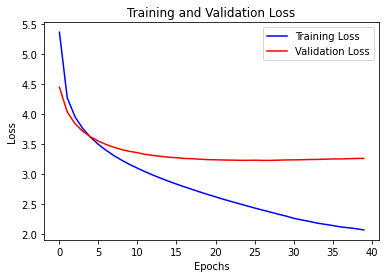

In [78]:
import matplotlib.pyplot as plt

epochs = range(0, len(training_loss))

# Plot the data
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, valid_loss, 'r-', label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the plot
plt.savefig('loss_plot.jpg')

In [54]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [55]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [108]:
import sys
def generate_caption(K, img_nm): 
    img_loc = '../input/flickr8k/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    valid_img_df['caption'] = valid_img_df['caption'].apply(lambda caption : [word.lower() if word.isalpha() else '' for word in caption.split(" ")]).apply(lambda x : remove_single_char_word(x))
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    return valid_img_df['caption'], image, predicted_sentence


# BLEU Score

In [182]:
list_bleu = []
for i in range(0, len(unq_valid_imgs)):
    target, img_test, predict = generate_caption(1, unq_valid_imgs.iloc[i]['image'])
    references = [target.tolist()]
    candidates = [predict]
    bleu_score = corpus_bleu(references, candidates)
    list_bleu.append(bleu_score)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [187]:
average = sum(list_bleu) / len(list_bleu)

print("Average:", average)
max_value = max(list_bleu)
min_value = min(list_bleu)

max_index = list_bleu.index(max_value)
min_index = list_bleu.index(min_value)

print("Max value:", max_value)
print("Max index:", max_index)
print("Min value:", min_value)
print("Min index:", min_index)

Average: 0.5361816000433705
Max value: 1.0
Max index: 297
Min value: 0
Min index: 14


In [191]:

zero_indices = [i for i, value in enumerate(list_bleu) if value == 0]

print("Indices with value 0:", zero_indices)
len(zero_indices)

Indices with value 0: [14, 116, 168, 175, 186, 265, 359, 422, 467, 494, 524, 553, 575, 743, 749, 808, 813, 1009, 1086, 1123, 1188]


21

In [242]:
print(zero_indices[::-1])

[14, 116, 168, 175, 186, 265, 359, 422, 467, 494, 524, 553, 575, 743, 749, 808, 813, 1009, 1086, 1123, 1188]


In [192]:
one_indices = [i for i, value in enumerate(list_bleu) if value == 1]
print("Indices with value 1:", one_indices)
len(one_indices)

Indices with value 1: [297, 478, 563]


3

In [267]:
targets= []
imgs =  []
predicts = []
indices = [14, 494, 186]
for i in indices:
    target, img_test, predict = generate_caption(1, unq_valid_imgs.iloc[i]['image'])
    targets.append(target)
    imgs.append(img_test)
    predicts.append(predict)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


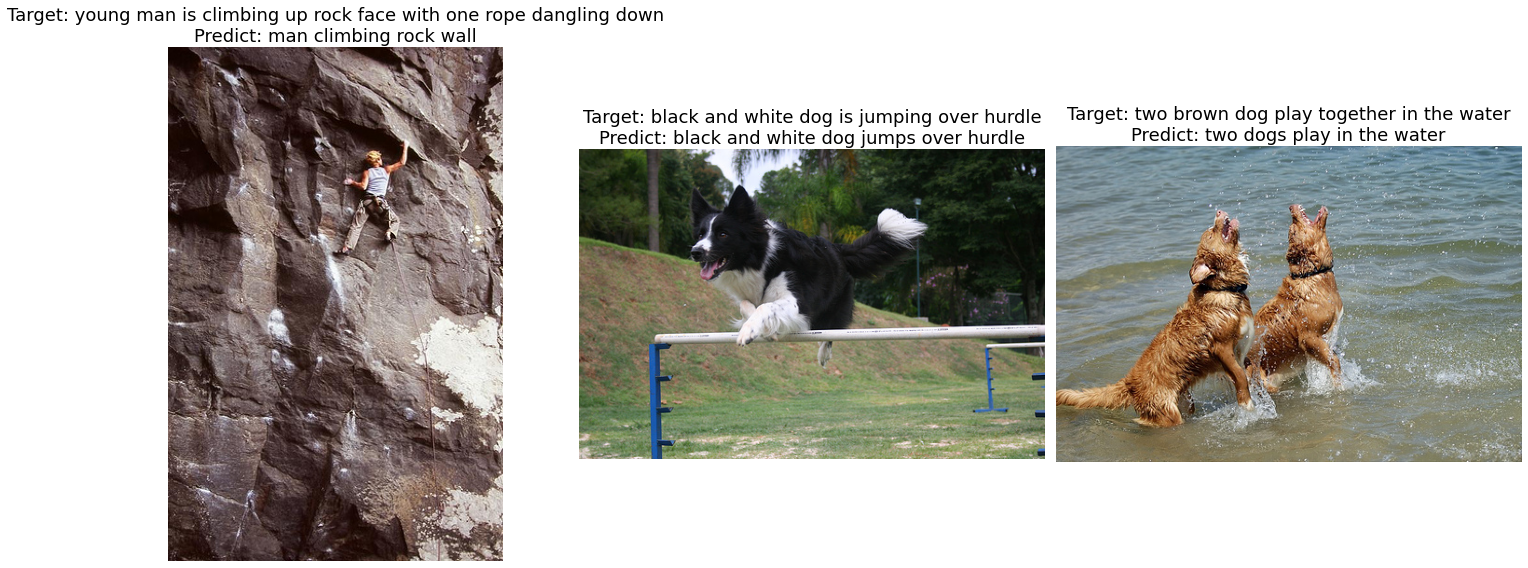

In [263]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

for i in range(3):
    # Display theimage
    axs[i].imshow(imgs[i])
    axs[i].axis('off')  # Hide the axes

    # Set the title to target and predict
    axs[i].set_title(f"Target: {' '.join(targets[i].tolist()[0])}\nPredict: {' '.join(predicts[i])}", fontsize=18)

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig("hghst.jpg")
# Show th plot
plt.show()

In [259]:
!pip install gtts

     |████████████████████████████████| 62 kB 975 kB/s  eta 0:00:01
     |████████████████████████████████| 171 kB 58.3 MB/s eta 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


In [268]:
from gtts import gTTS

import os
for i in range(3) :
    mytext = ' '.join(predicts[i])
    language = 'en'
    myobj = gTTS(text=mytext, lang=language, slow=False)
    myobj.save(f"{mytext}.mp3")